# Evaluation of performance of the algorithm on Yale Database 

### Imports & Définition de fonctions utiles

In [1]:
import random
random.seed(2017)
import time
import os, sys

In [2]:
from algorithme1 import *
import algorithme1

In [3]:
def read_images(path, sz=None,sz0=168,sz1=192): 
    '''
    Chargement des données
    Si spécifiée, réduction de dimensions incluse
    '''
    c=0
    X,y = [], []
    for dirname , dirnames , filenames in os.walk(path):
        for subdirname in dirnames:
            subject_path = os.path.join(dirname , subdirname) 
            for filename in os.listdir(subject_path):
                try:
                    im = Image.open(os.path.join(subject_path , filename)) 
                    im = im.convert("L")
                    # resize to given size (if given) and check that it's the good size
                    if ((im.size[0] == sz0) & (im.size[1]==sz1)):
                        if (sz is not None):
                            im = im.resize(sz, Image.NEAREST)     
                        X.append(np.asarray(im, dtype=np.uint8)) 
                        y.append(c)
                except IOError:
                    pass
                except:
                    print "Unexpected error:", sys.exc_info()[0] 
                    raise
            c = c+1
            
    print "Images chargees !"
    return [X,y]

### Chargement des images

In [4]:
path_images = 'data/CroppedYale/' # On détermine ici sur quelles images on veut s'entrainer

# D'abord on charge les images originales (utilisées pour la visualisation et la reconstruction)

X_original, y_original = read_images(path_images, sz=None)

Images chargees !


### Separation in training set and test set

In [5]:
Xtrain, Xtest = [], []
ytrain, ytest = [], []
indices_train, indices_test = [], []

for i in range(len(X_original)):
    if i%64==0:
        # On compute les indices des éléments à placer dans le test, ils sont différents pour chaque image.
        test1 = np.random.choice(28,5,replace=False)
        test2 = 29 + np.random.choice(35,7,replace=False)
    
    # On crée X_test et X_train
    if ((i%64 in test1) or (i%64 in test2)):
        Xtest.append(X_original[i])
        ytest.append(y_original[i])
        indices_test.append(i)
    else:
        Xtrain.append(X_original[i])
        ytrain.append(y_original[i])
        indices_train.append(i)

## Obtention du meilleur lambda

Note : la méthode d'obtention n'est pas très rigoureuse mais il est içi relativement difficile de faire des train / test sets équilibrés sachant que certaines images sont vraiment trop noires, et qu'une cross validation à la main prendrait un peu de temps.

On note également que l'implémentation pour l'occlusion et le bruitage n'est pas la bonne, il faut juste tester sans bruit ! Pour la bonne méthode d'occlusion et de bruitage voir le notebook *sparse representation implementation*

In [21]:
elem = 300
X_test_new = [Xtest[elem]]

In [37]:
algorithme1 = reload(algorithme1)

In [ ]:
alpha_vec = [0.002]
methods = [None]
accuracy = np.zeros((len(methods),len(alpha_vec)))

for i, alpha in enumerate(alpha_vec):
    for j,m in enumerate(methods):
        # Génération des résultats
        L = algorithme1.SRC(Xtrain, Xtest, ytrain, type_feature_reduc=m, reduce_lines=96, reduce_columns=84, lambda_val=alpha, per_bruit=0.3, pos_occl=None)
        
        # Obtention de la précision
        predictions = []
        residus = []
        sci = []
        for a,b,c in L:
            residus.append(a)
            predictions.append(b)
            sci.append(c)
        predictions = np.asarray(predictions)
        accuracy[j,i] = 100.0*np.sum((predictions == ytest))/len(Xtest)
    print("lambda = ", alpha, ", fini")
        
        

/Users/maxwab/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/maxwab/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/maxwab/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/maxwab/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not co

In [ ]:
accuracy

In [20]:
predictions

array([1])

2.41228070175


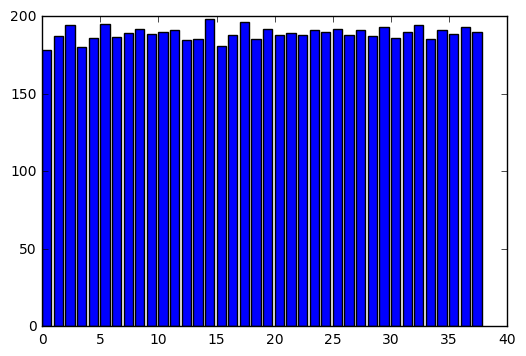

11
0


In [10]:
elem = 139
cpt = 0
for el in range(len(Xtest)):
    if ytest[el] == np.argmin(residus[el]):
        cpt = cpt+1
cpt = 100.0*cpt/len(Xtest)

print cpt

plt.figure()
plt.clf()
plt.bar(range(residus[0].shape[0]),residus[elem])
plt.show()
print(ytest[elem])
print np.argmin(residus[elem])

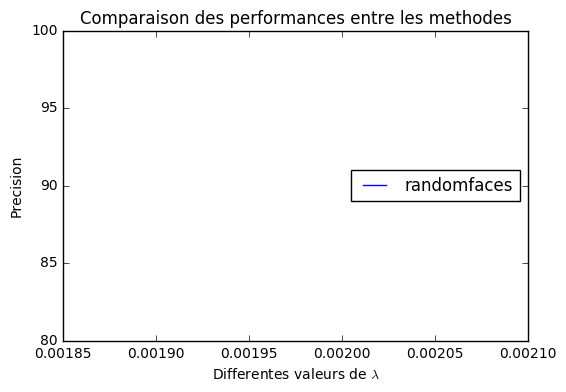

In [11]:
plt.figure()
plt.clf()
plt.hold(True)
for j,m in enumerate(methods):
    plt.plot(alpha_vec,accuracy[j,:],label=str(m))
plt.legend(loc=7)
plt.title('Comparaison des performances entre les methodes')
plt.xlabel('Differentes valeurs de $\lambda$')
plt.ylabel('Precision')
plt.ylim([80, 100])
plt.show()


In [12]:
import pandas as pd

In [13]:
pd.DataFrame(data=predictions).to_csv('csv_saved/preds_all.csv')